In [1]:
import sys
from notebooks_utils import *
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm

In [10]:
def add_position_class(df):
    position_classes = []
    last_positions = {}

    base_strings = df.base_string.unique()
    for s in tqdm(base_strings):
        last_positions[s] = df[df.base_string == s].position.max()

    pbar = tqdm(total=len(df))
    for i, r in df.iterrows():
        last_pos = last_positions[r.base_string]

        if r.position < r.op1_pos:
            position_classes.append('Early')
        elif r.position == r.op2_pos:
            position_classes.append('2nd Operand')
        elif r.position == r.op1_pos:
            position_classes.append('1st Operand')
        elif r.op1_pos < r.position < r.op2_pos:
            position_classes.append('Middle')
        elif r.position == last_pos:
            position_classes.append('Last')
        elif r.position > r.op2_pos:
            position_classes.append('Late')
        else:
            raise Exception('this should not happen')

        pbar.update(1)

    df['position_class'] = position_classes

    
def add_position_class_lama(df):
    position_classes = []
    last_positions = {}

    base_strings = df.base_string.unique()
    for s in tqdm(base_strings):
        last_positions[s] = df[df.base_string == s].position.max()

    pbar = tqdm(total=len(df))
    for i, r in df.iterrows():
        last_pos = last_positions[r.base_string]

        if r.position < r.op1_pos:
            position_classes.append('Early')
        elif r.position == r.op2_pos:
            position_classes.append('Subj Last Tok')
        elif r.position == r.op1_pos:
            position_classes.append('Subj First Tok')
        elif r.op1_pos < r.position < r.op2_pos:
            position_classes.append('Other Subj Toks')
        elif r.position == last_pos:
            position_classes.append('Last')
        elif r.position > r.op2_pos:
            position_classes.append('Late')
        else:
            raise Exception('this should not happen')

        pbar.update(1)

    df['position_class'] = position_classes
    
    
    
def add_position_class_3_ops(df):
    position_classes = []
    last_positions = {}

    base_strings = df.base_string.unique()
    for s in tqdm(base_strings):
        last_positions[s] = df[df.base_string == s].position.max()

    pbar = tqdm(total=len(df))
    for i, r in df.iterrows():
        last_pos = last_positions[r.base_string]

        if r.position < r.op1_pos:
            position_classes.append('Early')
        elif r.position == r.op2_pos:
            position_classes.append('2nd Operand')
        elif r.position == r.op1_pos:
            position_classes.append('1st Operand')
        elif r.position == r.op3_pos:
            position_classes.append('3rd Operand')
        elif r.op1_pos < r.position < r.op2_pos:
            position_classes.append('Between Operands 1')
        elif r.op2_pos < r.position < r.op3_pos:
            position_classes.append('Between Operands 2')
        elif r.position == last_pos:
            position_classes.append('Last')
        elif r.position > r.op3_pos:
            position_classes.append('Late')
        else:
            raise Exception('this should not happen')

        pbar.update(1)

    df['position_class'] = position_classes
    
    
def add_position_class_int11(df):
    position_classes = []
    last_positions = {}

    base_strings = df.base_string.unique()
    for s in tqdm(base_strings):
        last_positions[s] = df[df.base_string == s].position.max()

    pbar = tqdm(total=len(df))
    for i, r in df.iterrows():
        last_pos = last_positions[r.base_string]


        if r.position < r.entity_q_first:
            position_classes.append('Early')
        elif r.position == r.entity_q_first:
            position_classes.append('$e_q$ 1st Tok')
        elif r.entity_q_first < r.position < r.entity_q_last:
            position_classes.append('$e_q$ Mid Toks')
        elif r.position == r.entity_q_last:
            position_classes.append('$e_q$ Last Tok')
        elif r.position == last_pos:
            position_classes.append('Last')
        elif r.position > r.entity_q_last:
            position_classes.append('Late')
        else:
            position_classes.append('Other Toks')

        pbar.update(1)

    df['position_class'] = position_classes

def plot_effects_across_tokens(df, figsize=(15, 6), title='Indirect Effect', representation='arabic',
                               heatmap=False, measure='absolute_diff', vmax=None, vmin=0.1, cmap="YlOrRd"):
    if 'position_class' not in df.columns:
        if '+' in df.operation.unique():
            # 2 operands
            add_position_class(df)
        elif 'x or y' == df.equation[0]:
            # int 11
            add_position_class_int11(df)
        elif df.equation[0].startswith('LAMA'):
            add_position_class_lama(df)
        else:
            # 3 operands
            add_position_class_3_ops(df)
            
        
    cols = [
        'neuron', 'layer', 'accuracy',
        'total_effect', 'effect', 'effect_diff_int2', 'effect_increase_p_res_alt', 'effect_average_diff',
        'effect_relative_increase_p_res_alt'
    ]
    
    compute_effects(df, representation)
    
    if not heatmap:

        for pos_class in df.position_class.unique():
            df_pos = df[df.position_class == pos_class]
            layer_aggregated = df_pos[cols].groupby(['layer', 'neuron']).agg(['mean', 'max', 'std', 'sem'])
            layer_aggregated.columns = ['_'.join(col) for col in layer_aggregated.columns]
            plot_layer_aggregated(layer_aggregated, figsize=figsize, title=f'{title} ({pos_class})')
            
    else:
        matrix = {}
        pos_classes = list(df.position_class.unique())
        pos_classes.remove('Last')
        if 'Early' in pos_classes:
            pos_classes.remove('Early')
        pos_classes = ['Early'] + pos_classes
        pos_classes += ['Last']
        if 'x or y' == df.equation[0]:
            pos_classes = ['Early', '$e_q$ 1st Tok', '$e_q$ Mid Toks', '$e_q$ Last Tok', 'Late', 'Last' ]
        sum_of_eff = 0
        for pos_class in pos_classes:
            df_pos = df[df.position_class == pos_class]
            layer_aggregated = df_pos[cols].groupby(['layer', 'neuron']).agg(['mean', 'max', 'std', 'sem'])
            layer_aggregated.columns = ['_'.join(col) for col in layer_aggregated.columns]
            norm = None
            if measure == 'diff_int2':
                matrix[pos_class] = layer_aggregated.reset_index().drop('neuron', axis=1).effect_diff_int2_mean
            elif measure == 'p_res_increase':
                matrix[pos_class] = layer_aggregated.reset_index().drop('neuron', axis=1).effect_increase_p_res_alt_mean
            elif measure == 'absolute_diff':
                matrix[pos_class] = layer_aggregated.reset_index().drop('neuron', axis=1).effect_average_diff_mean
            elif measure == 'relative_diff':
                matrix[pos_class] = layer_aggregated.reset_index().drop('neuron', axis=1).effect_mean
                norm = LogNorm(vmax=vmax)
                matrix[pos_class][matrix[pos_class] <= vmin] = vmin
            elif measure == 'relative_p_res_increase':
                matrix[pos_class] = layer_aggregated.reset_index().drop('neuron', axis=1).effect_relative_increase_p_res_alt_mean
                norm = LogNorm(vmax=vmax)
                matrix[pos_class][matrix[pos_class] <= vmin] = vmin
            else:
                print('wrong measure')
            sum_of_eff += sum(np.log(matrix[pos_class] + 1))
        
            
        eff_of_last = sum(np.log(matrix['Last'][int(len(matrix['Last']) / 2):] + 1))
        print(f'Contribution of mid-late MLPs at last token: {eff_of_last} ({eff_of_last/sum_of_eff})')
        heatmap_df = pd.DataFrame(matrix).transpose()
        fig = plt.figure(figsize=figsize)
        ax = sns.heatmap(heatmap_df, robust=False, vmax=vmax, cmap=cmap, figure=fig, norm=norm, xticklabels=5)
        ax.set_facecolor('white')
        ax.set(xlabel="Layer", ylabel="")
        plt.title(title)
        plt.tight_layout(pad=0)

# Plot IE for each component in the model.

Contribution of mid-late MLPs at last token: 1.4296526970648744 (0.0807471590316264)



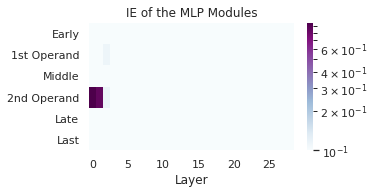

In [12]:
model_name = 'EleutherAI/gpt-j-6B'
intervention = 1
seed= '0'
max_n = 300
examples_n = 5
n_shots=0
representation='arabic'

path_prefix = '../out'

split_ops = False

path = f'{path_prefix}/{model_name}/n_operands2/template_typeall'
path += f'/max_n{max_n}/n_shots{n_shots}/examples_n{examples_n}/seed{seed}/'
path += f'intervention_{intervention}_{representation}_indirect_layer_all_tokens.feather'

df_mlp = pd.read_feather(path)
plot_effects_across_tokens(df_mlp, heatmap=True, figsize=(5,2.5), vmax=None,
                           measure='relative_diff', cmap='BuPu',
                           title='IE of the MLP Modules')
plt.tight_layout(pad=0)